# Uninterrupted character-level input with token representation using GNN

Ideas:<br>
 - Continuous unpadded/untruncated character sequences
 - Generate graph after token representation inside model
 - Using dynamic sparse GNN

Test Results:
| metric | test 1 | test 2 | test 3 | test 4 | test 5 | Average |
|:---|:--:|:--:|:--:|:--:|:--:|:--:|
| f1-score | 
| accuracy | 
| precision |
| recall | 
| loss | 

## Import Packages

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt
import random
from torch_scatter import scatter_max, scatter_mean, scatter_sum, scatter_std
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader
from copy import copy
import spacy
from umap import UMAP

import os
import PyPDF2
from bs4 import BeautifulSoup
# import textract
import json
import gzip
import re
import collections
import csv
import string

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1
folder_path = r'data\CrawledWeb\TopicClassification\HTMLClassification\htmls'
urls_df = pd.read_csv(r'data\CrawledWeb\TopicClassification\URLClassification\url_classes2.csv')
device

FileNotFoundError: [Errno 2] No such file or directory: 'data\\CrawledWeb\\TopicClassification\\URLClassification\\url_classes2.csv'

## Data Classes and Functions

In [3]:
with open(r'data\reduced_embeddings\spacy_lg_reduced_embeddings.npy', 'rb') as f:
    embeddings = np.load(f)
nlp = spacy.load('en_core_web_lg', disable=['tok2vec','tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])
t_tokenizer = TweetTokenizer()
nlp.max_length = len(' '.join(list(nlp.vocab.strings)))+1
all_vocab_doc = nlp(' '.join(list(nlp.vocab.strings)))
all_vocab_str = [f'{t}' for t in all_vocab_doc]
embeddings = torch.from_numpy(embeddings)
embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
token_vocab_dict = dict(zip(all_vocab_str, embeddings))
token_vocab_dict['<n>'] = token_vocab_dict['newline']
len(token_vocab_dict)

771064

In [4]:
with gzip.open(rf'data\CrawledWeb\TopicClassification\ExtractedWebTexts\web_contents_reduced.json.gz', 'rt') as file:
    web_contents = json.load(file)
web_contents = {int(k):v for k, v in web_contents.items()}
doc_lengths = np.array([len(web_contents[i]) for i in web_contents])
list(web_contents.keys())[torch.topk(torch.from_numpy(doc_lengths), 5).indices[1].item()]
# torch.topk(torch.from_numpy(doc_lengths), 5)

2744

In [5]:
web_contents[list(web_contents.keys())[torch.topk(torch.from_numpy(doc_lengths), 5).indices[1].item()]][1000000:1000300]

'countable y related activities are limited solely to required conditioning activities and / or <n> in skil - related instruction are not required to count toward the 132 - day season ; <n> During any we k in which practice or competition oc urs , a student - involvement in countable y <n> related ac'

In [6]:
active_indices = np.array(list(web_contents.keys()), dtype=np.int32)
df = pd.read_csv(r'data\CrawledWeb\TopicClassification\URLClassification\url_classes2.csv')
df = df.iloc[active_indices]
train_indices, val_indices = train_test_split(active_indices, test_size=0.1)

In [7]:
class_list = df.Topic.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}

In [8]:
allowed_chars = string.ascii_letters + string.digits + string.punctuation + ' '
all_chars = set(allowed_chars)
vocab_dict = {c:i for i, c in enumerate(allowed_chars)}
if '\x01' not in vocab_dict:
    vocab_dict['\x01'] = len(vocab_dict)
char_Set = set(vocab_dict.keys())

In [9]:
list(web_contents.keys())[torch.topk(torch.from_numpy(doc_lengths), 1000).indices[999].item()]

7571

In [10]:

len(web_contents[7571][:138000])

52091

In [11]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, indices, num_classes, char_dict, token_dict, tokenizer, max_doc_length=10000) -> None:
        super().__init__()
        y = y[indices].values
        y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        
        self.char_dict = char_dict
        self.char_Set = set(char_dict.keys())
        self.vocab_size = len(self.char_dict)
        self.tokenizer = tokenizer
        
        self.all_data = []# torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        # self.token_lengths = torch.zeros((len(X), self.doc_teken_length), dtype=torch.int)
        # self.token_indices = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        self.token_lengths = []
        
        self.token_embeddign_ids = []
        for i in indices:
            doc=X[i][:max_doc_length]
            
            tokens = tokenizer(''.join(c for c in doc if c in self.char_Set))
            tokens = [t for t in tokens] if len(tokens) > 0 else ['empty']
            tokens.append('\x01')
            token_embs = [token_dict[t] if t in token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
            token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
            doc = ' '.join(tokens)
            
            # for t in set(doc):
            #     self.char_dict.setdefault(t, len(self.char_dict))

            characters = torch.from_numpy(np.array([self.char_dict[t] for t in doc], dtype=np.longlong))
            # char_pad_size = max(self.doc_char_length - len(indices), 0)
            # indices = torch.nn.functional.pad(indices[:self.doc_char_length], (0,char_pad_size))
            
            token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
            token_lengths[-1] -= 1
            token_positions = torch.arange(len(token_lengths), dtype=torch.long)
            token_indices = torch.repeat_interleave(token_positions, token_lengths)
            # token_indices = torch.nn.functional.pad(token_indices[:self.doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
            
            # self.token_embeddign_ids.append(token_embs)
            g_data = Data(x=characters,
                          token_positions=token_positions,
                          character_length = len(characters),
                          num_tokens = len(token_lengths),
                          token_indices=token_indices,
                          token_lengths=token_lengths,
                          token_embeddings=token_embs)
            
                        #   character_token_lengths = torch.repeat_interleave(token_lengths, token_lengths)
            
            self.all_data.append(g_data)
            # self.token_lengths.append(token_lengths)
        
        
    def __getitem__(self, index):
        # emb_data = Data(x=self.token_embeddigns[self.token_embeddign_ids[index]])
        return self.all_data[index], self.y[index]#, Batch.from_data_list([emb_data])
        
    def __len__(self):
        return len(self.y)
        

In [12]:
from typing import List
import torch
from torch_geometric.loader import DataLoader

# from scripts.data.datasets.GraphConstructorDataset3 import WordGraphLabeledDataset

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


## Prepare Data

In [13]:
doc_lengths

array([ 1736,  7107,  9739, ..., 46382, 19626,  7334])

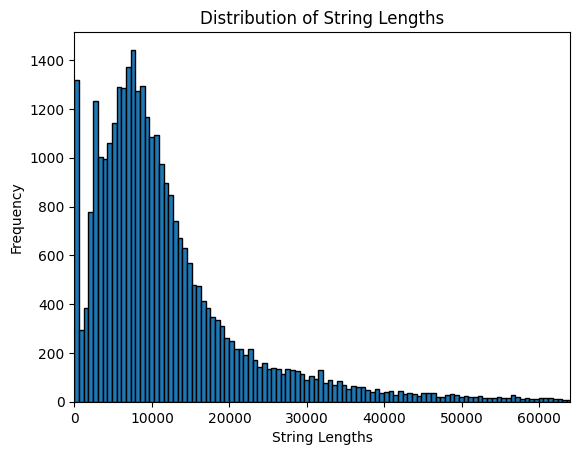

In [14]:
# Create a histogram
plt.hist(doc_lengths, bins='auto', edgecolor='black')
plt.xlim([0,64000])
# Add labels and title
plt.xlabel('String Lengths')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')

# Show the chart
plt.show()

In [15]:
batch_size = 128
max_doc_length=2048

In [16]:
train_dataset = CharacterandTokenLevelCustomDataset(web_contents, df.Topic, train_indices, len(class_id), vocab_dict, token_vocab_dict, t_tokenizer.tokenize, max_doc_length=max_doc_length)
test_dataset = CharacterandTokenLevelCustomDataset(web_contents, df.Topic, val_indices, len(class_id), vocab_dict, token_vocab_dict, t_tokenizer.tokenize, max_doc_length=max_doc_length)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [17]:
num_embedding = len(vocab_dict)
# del web_contents
# del train_indices
# del vocab_dict
# del token_vocab_dict
# del nlp
# del val_indices
# del df
# del active_indices
# del doc_lengths
# del embeddings

In [18]:
# batch_size = 64
# train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
# test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [19]:
# X,y = next(iter(test_dataset))
# print(f'X.character_length: {X.character_length}')
# print(f'X.num_tokens: {X.num_tokens}')
# print(f'X.token_indices: {X.token_indices}')
# print(f'len(X.token_indices): {len(X.token_indices)}')
# print(f'sum(X.token_lengths): {sum(X.token_lengths)}')
# print(f'X.token_embeddings.shape: {X.token_embeddings.shape}')

In [20]:
import math

In [21]:
X, y = next(iter(test_dataloader))

In [22]:
X

DataBatch(x=[255066], token_positions=[49831], character_length=[128], num_tokens=[128], token_indices=[255066], token_lengths=[49831], token_embeddings=[49831, 64], batch=[255066], ptr=[129], cumulative_token_indices=[255066])

## Model Classes and Functions

In [23]:
from torch_geometric.nn import GATv2Conv, SimpleConv

class GCNN(nn.Module):
    def __init__(self, hidden_dim, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        # self.hidden_dim = hidden_dim
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4)
        # self.gnn = SimpleConv(aggr='mean')
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        # self.out_fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        # self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        # self.bn4 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x, graph, total_token_count, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, graph.edge_index, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x[:total_token_count].T).T)#self.bn2(self.conv(x[:total_token_count].T).T))
        x3 =  F.leaky_relu_(self.bn3(self.fc(x1[total_token_count:])))
        x1 = F.leaky_relu_(self.bn1(x1[:total_token_count]))
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=0)
        # x = self.bn4(x)
        return x, edge_weights #F.leaky_relu_(self.bn4(self.out_fc(x)))

In [24]:
import networkx as nx
from torch_geometric.utils import to_networkx, to_undirected

class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_index = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(0, lattice_links.shape[1]*2, step=2):
        #     edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i].view(1,-1), tc_range], dim=0)
        #     edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
        # for i in range(lattice_links.shape[1]*2, lattice_links.shape[1]*2+random_links.shape[1]):
        #     edge_index[:, i*random_links.shape[0]:(i+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_coutns )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_coutns, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_index[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_index[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
        
    def re_gen_graph(self, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_index, random_links, lattice_links, tc_range)
        # for i in range(base.shape[1]):
        #     edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
            
        return Batch.from_data_list([Data(x=x, edge_index=edge_index)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_index, total_token_coutns, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_coutns*self.virtual_nodes
        if v_n_e_counts>0:
            important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        else:
            important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()

        important_indices = torch.arange(total_token_coutns, dtype=torch.int64, device=x.device) + important_indices*total_token_coutns
        important_indices = important_indices.view(-1)
        random_links, lattice_links, tc_range = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, tc_range)
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_index[:, important_indices]
        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_index[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([tc_range, base[:,i].view(1,-1)], dim=0)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
         
    def calculate_graph(self, x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance):
        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        tc_range = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        random_ints = torch.randint(0, 2*total_token_coutns, (total_token_coutns, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = torch.arange(lattice_start_distance, self.lattice_step*lattice_edges+1, self.lattice_step, device=x.device).view(1, -1)

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = tc_range - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        # base = torch.cat([base1, base2], dim=1)
        tc_range = tc_range.view(1,-1)
        return random_links, lattice_links, tc_range
    
    def fill_lattice_and_random_edges(self, edge_index, random_links, lattice_links, tc_range):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), tc_range], dim=0)
            edge_index[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_index[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_index[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), tc_range], dim=0)

In [25]:
# torch.max(X.x)

In [26]:
# embedding = nn.Embedding(len(vocab_dict), 64)
# x = embedding(X.x)
# x = scatter_mean(x.T, X.cumulative_token_indices, dim=1)

# graph_generator = GenGraph(64, 1, 2)
# graph = graph_generator.gen_graph(x.T, len(X.token_lengths), X.num_tokens, 2, 2)
# gcnn1 = GCNN(64)
# x, edge_weights = gcnn1(graph.x, graph, len(X.token_lengths), return_attention_weights = True)
# edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
# # edge_weights = torch.sum(edge_weights[1][:graph.edge_index.shape[1], :],dim=1)
# graph = graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(X.token_lengths), X.num_tokens, 4, 4, p_keep=2, lattice_start_distance=3)
# graph

In [27]:
# weights.T[0].view(-1, len(X.token_lengths))

In [28]:
# r_v = torch.randn(5, 6)
# torch.topk(r_v, 2, dim=0)
# r_v
# len(graph.x)
# edge_weights.view(-1, len(X.token_lengths))
# important_indices = torch.topk(weights.T[0][:-1*len(X.token_lengths)].view(-1, len(X.token_lengths)), 1, dim=0).indices.squeeze()
# print(important_indices)
# print(torch.arange(important_indices.shape[0]) + important_indices*important_indices.shape[0])

In [29]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, max_token_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_token_count = max_token_count
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        if seed>-1:
            torch.manual_seed(seed)
 
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        
        self.dropout = nn.Dropout(p=dropout)

        self.positional_encoding = nn.Embedding(max_token_count, embedding_dim)
        self.positional_encoding.weight = self.create_positional_encoding()

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)

        # self.conv5 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(2*hidden_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 32
        self.fc0 =  nn.Linear(hidden_dim , 2*hidden_dim)
        self.fc1 = nn.Linear(2*hidden_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        # self.fc3 = nn.Linear(hidden_dim * k, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, g_data):
        # rand_edges = self.get_random_edge_count(g_data.x.shape[0])
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        x = torch.cat([x1, x2], dim=0)


        x = F.relu(self.conv3(x)) 
        x = x.T + self.positional_encoding(g_data.token_positions)
        # x = self.dropout(x)
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
        graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1 # max(1, rand_edges-1)
        lattice_edges = lattice_edges-1 # max(1, lattice_edges-1)
        # self.gen_graph(x.T, len(g_data.token_lengths), g_data.num_tokens)
        # x = torch.cat([graph.x, g_data.token_embeddings], dim=1)
        
        x, edge_weights = self.gcnn1(graph.x, graph, len(g_data.token_lengths), return_attention_weights = True)
        # edge_weights = torch.sum(edge_weights[1][:graph.edge_index.shape[1], :],dim=1)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        x = torch.cat([
            graph.x[:g_data.token_embeddings.shape[0]] + self.positional_encoding(g_data.token_positions), 
            g_data.token_embeddings + self.positional_encoding(g_data.token_positions)], dim=1)
        x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        # x = x + graph.x  /////
        # graph = self.graph_generator.re_gen_graph(x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens)    //////
        #self.re_gen_graph(x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens)
        x, edge_weights = self.gcnn2(x, graph, len(g_data.token_lengths))
        # x = x + x1  /////
        x = F.elu_(self.fc1(x))
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


    def create_positional_encoding(self):
        position = torch.arange(self.max_token_count).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.max_token_count, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)


In [30]:
from torch_geometric.nn import GATv2Conv, SimpleConv, summary

class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, max_token_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, random_edges=4, lattice_edges=10, virtual_nodes=1, lattice_step=2, lattice_start_distance=2, use_positional_encoder=[False, False, False], *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        self.max_token_count = max_token_count
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.virtual_nodes = virtual_nodes
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.use_positional_encoder = use_positional_encoder
        if seed>-1:
            torch.manual_seed(seed)
 
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        
        
        self.dropout = nn.Dropout(p=dropout)

        self.positional_encoding = nn.Embedding(max_token_count, embedding_dim)
        self.positional_encoding.weight = self.create_positional_encoding()

        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)

        # self.conv5 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        self.gcnn1 = GCNN(hidden_dim)
        self.gcnn2 = GCNN(2*hidden_dim)
        self.graph_generator = GenGraph(hidden_dim, virtual_nodes, lattice_step)
        
        k = 32
        self.fc0 =  nn.Linear(hidden_dim , 2*hidden_dim)
        self.fc1 = nn.Linear(2*hidden_dim , hidden_dim * k)
        self.fc2 = nn.Linear(hidden_dim * (2+virtual_nodes) * k , 32)
        # self.fc3 = nn.Linear(hidden_dim * k, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, g_data):
        # rand_edges = self.get_random_edge_count(g_data.x.shape[0])
        x = self.embedding(g_data.x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, g_data.cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, g_data.cumulative_token_indices, dim=1)

        x = torch.cat([x1, x2], dim=0)


        x = F.relu(self.conv3(x)).T
        
        if self.use_positional_encoder[0]:
            x = x + self.positional_encoding(g_data.token_positions)
        # x = self.dropout(x)
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
        graph = self.graph_generator.gen_graph(x, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        rand_edges = rand_edges-1 # max(1, rand_edges-1)
        lattice_edges = lattice_edges-1 # max(1, lattice_edges-1)
        # self.gen_graph(x.T, len(g_data.token_lengths), g_data.num_tokens)
        # x = torch.cat([graph.x, g_data.token_embeddings], dim=1)
        
        x, edge_weights = self.gcnn1(graph.x, graph, len(g_data.token_lengths), return_attention_weights = True)
        # edge_weights = torch.sum(edge_weights[1][:graph.edge_index.shape[1], :],dim=1)
        edge_weights = edge_weights[1][:graph.edge_index.shape[1], 0]
        
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens, rand_edges, lattice_edges, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        
        # x = torch.cat([graph.x[:g_data.token_embeddings.shape[0]] + self.positional_encoding(g_data.token_positions), g_data.token_embeddings + self.positional_encoding(g_data.token_positions)], dim=1)
        
        if self.use_positional_encoder[1]:
            xa = graph.x[:g_data.token_embeddings.shape[0]] + self.positional_encoding(g_data.token_positions)
        else:
            xa = graph.x[:g_data.token_embeddings.shape[0]]
        if self.use_positional_encoder[2]:
            xb = g_data.token_embeddings + self.positional_encoding(g_data.token_positions)
        else:
            xb = g_data.token_embeddings
        
        x = torch.cat([xa, xb], dim=1)
        # x = torch.cat([graph.x[:g_data.token_embeddings.shape[0]], g_data.token_embeddings], dim=1)
        x1 = F.relu(self.fc0(graph.x[g_data.token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        # x = x + graph.x  /////
        # graph = self.graph_generator.re_gen_graph(x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens)    //////
        #self.re_gen_graph(x, graph.edge_index, len(g_data.token_lengths), g_data.num_tokens)
        x, edge_weights = self.gcnn2(x, graph, len(g_data.token_lengths))
        # x = x + x1  /////
        x = F.elu_(self.fc1(x))
        doc_token_index = torch.repeat_interleave(torch.arange(len(g_data.num_tokens), device=x.device), g_data.num_tokens)
        x1 = scatter_max(x[:len(g_data.token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(g_data.token_lengths)], doc_token_index, dim=0)
        vn_embs = x[len(g_data.token_lengths):]
        x_for_cat = [x1, x2]
        x_for_cat.extend([vn_embs[i*x1.shape[0]:(i+1)*x1.shape[0]] for i in range(self.virtual_nodes)])
        x = torch.cat(x_for_cat, dim=1)
        
        x = F.elu_(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x


    def create_positional_encoding(self):
        position = torch.arange(self.max_token_count).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * (-math.log(10000.0) / self.hidden_dim))
        pe = torch.zeros(self.max_token_count, self.hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return torch.nn.Parameter(pe, requires_grad=False)


In [31]:
model = CNN_for_Text(num_embedding=num_embedding, batch_size=batch_size, max_token_count=256, embedding_dim=128, hidden_dim=64, num_out_features=len(class_id), random_edges=4, lattice_edges=4, virtual_nodes=0)#.to(device)
print(summary(model, X.cpu()))
# del model

+-------------------------------------------+------------------------------+----------------+----------+
| Layer                                     | Input Shape                  | Output Shape   | #Param   |
|-------------------------------------------+------------------------------+----------------+----------|
| CNN_for_Text                              | [255066, 255066]             | [128, 12]      | 593,932  |
| ├─(embedding)Embedding                    | [255066]                     | [255066, 128]  | 12,288   |
| ├─(dropout)Dropout                        | [255066, 128]                | [255066, 128]  | --       |
| ├─(positional_encoding)Embedding          | --                           | --             | 16,384   |
| ├─(conv1)Conv1d                           | [128, 255066]                | [64, 255066]   | 41,024   |
| ├─(pool1)MaxPool1d                        | --                           | --             | --       |
| ├─(conv2)Conv1d                           | [64, 2550

In [32]:
# model = model.eval()
# with torch.no_grad():
#     model(X.cpu()).shape #.to(device)
torch.cuda.empty_cache()

In [33]:

class CnnGnnClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CnnGnnClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters("model", logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [34]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix


def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


## Test Model

In [35]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [36]:
import os
print(os.getcwd())

c:\Users\fardin\Projects\Form&ColorIntelligence


In [37]:
# from scripts.managers.ClassifierModelManager import ClassifierModelManager
from lightning.pytorch.loggers import CSVLogger
import lightning as L
# from scripts.managers.ClassifierModelManager import ClassifierModelManager

In [38]:
# Fardin Rastakhiz @ 2023
from abc import ABC, abstractmethod
from typing import List, Optional

import torch
import lightning as L
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import Logger, CSVLogger
from lightning.pytorch.tuner import Tuner
from typing import List
from pytorch_lightning.core.saving import save_hparams_to_yaml

class ModelManager(ABC):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 max_epochs = 100,
                 ckpt_path: str|None=None,
                 accumulate_grad_batches=1):
        self.torch_model = torch_model
        self.lightning_model = lightning_model
        self.log_dir = log_dir
        self.log_name = log_name
        self.model_save_dir = model_save_dir
        self.device = device
        self.accelerator = 'cpu' if self.device=='cpu' else 'gpu'
        self.max_epochs = max_epochs
        self.ckpt_path = ckpt_path

        self.logger = self._create_logger()
        self.callbacks = self._create_callbacks()
        self.trainer: L.Trainer = self._create_trainer(accumulate_grad_batches)
        self.tuner = Tuner(self.trainer)
        self.tuning_result = None

    def tune(self, data_manager=None, train_dataloaders=None, val_dataloaders=None, datamodule=None, draw_result=True, min_lr=0.0000001, max_lr=0.1):
        self.tuning_result = self.tuner.lr_find(self.lightning_model, datamodule=data_manager, train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders, min_lr=min_lr,max_lr=max_lr, num_training=150)
        if draw_result:
            fig = self.tuning_result.plot(suggest=True)
            fig.show()
        self.update_learning_rate(self.tuning_result.suggestion())
        return self.tuning_result.suggestion()
    
    def update_learning_rate(self, lr):
        self.lightning_model.update_learning_rate(lr)

    def fit(self, train_dataloaders=None, val_dataloaders=None, datamodule=None, max_epochs = -1, ckpt_path=None):
        if ckpt_path is not None and ckpt_path != '':
            self.ckpt_path = ckpt_path
        if max_epochs>0:
            self.trainer.fit_loop.max_epochs = max_epochs
            # self.max_epochs = max_epochs
            # self.trainer = self._create_trainer()
        self.trainer.fit(self.lightning_model,
                         datamodule=datamodule,
                         train_dataloaders=train_dataloaders,
                         val_dataloaders=val_dataloaders,
                         ckpt_path = self.ckpt_path
                         )

    def validate(self, dataloaders=None, datamodule=None):
        return self.trainer.validate(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def predict(self, dataloaders=None, datamodule=None):
        return self.trainer.predict(self.lightning_model,
                             datamodule=datamodule,
                             dataloaders=dataloaders)

    def _create_trainer(self, accumulate_grad_batches) -> L.Trainer:
        return L.Trainer(
            callbacks=self.callbacks,
            max_epochs=self.max_epochs,
            accelerator=self.accelerator,
            logger=self.logger,
            num_sanity_val_steps=0,
            default_root_dir=self.model_save_dir,
            accumulate_grad_batches=accumulate_grad_batches
        )

    @abstractmethod
    def _create_callbacks(self) -> List[Callback]:
        pass

    def _create_logger(self) -> Logger:
        return CSVLogger(save_dir=self.log_dir, name=self.log_name)

    @abstractmethod
    def draw_summary(self, dataloader):
        pass

    @abstractmethod
    def plot_csv_logger(self, loss_names, eval_names):
        pass
    
    def save_hyper_parameters(self):
        mhparams = {
            'start_lr': 0.045,
            'ckpt_lrs' :  {51: 0.002, 65: 0.00058},
            'last_lr' : 0.0003,
            'ac_loss_factor': 0.0002,
            'weight_decay': 0.0012
        }
        save_hparams_to_yaml(config_yaml=r'logs\hetero_model_17_AG\version_12\hparams.yaml',
                     hparams=mhparams)
        
    # def find_best_settings(data_manager,
    #                        lrs: List[float]=[0.001], dropouts: List[float]=[0.2], 
    #                        weight_decays: List[float]=[0.00055], emb_factors: List[float]=[0.1], 
    #                        batch_sizes: List[int]=[128], log_name='find_best_settings'):
    #     for lr in lrs:
    #         for dropout in dropouts:
    #             for wd in weight_decays:
    #                 for emb_factor in emb_factors:
    #                     for bs in batch_sizes:
    #                         data_manager.update_batch_size(bs)
    #                         torch_model = HeteroGcnGatModel1(300, 1, X1.metadata(), 128, dropout=dropout)
    #                         lightning_model = HeteroBinaryLightningModel(torch_model,
    #                                         torch.optim.Adam(torch_model.parameters(), lr=lr, weight_decay=wd),
    #                                             loss_func=HeteroLoss1(exception_keys='word', enc_factor=emb_factor),
    #                                             learning_rate=lr,
    #                                             batch_size=bs,
    #                                             user_lr_scheduler=True
    #                                             ).to(device)
    #                         model_manager = ClassifierModelManager(torch_model, lightning_model, log_name=log_name, device=device, num_train_epoch=10)
    #                         model_manager.fit(datamodule=data_manager)
    #                         model_manager.save_plot_csv_logger(name_prepend=f'{lr}_{dropout}_{wd}_{emb_factor}_{bs}', loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [39]:
# Fardin Rastakhiz @ 2023
import torch
# from scripts.managers.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

import lightning as L

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100,
                 accumulate_grad_batches=1):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch, accumulate_grad_batches=accumulate_grad_batches)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.lightning_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        if(give_hinge_loss):
            print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def evaluate_best_models(self, lightning_type: L.LightningModule, eval_dataloader,
                             give_confusion_matrix: bool=True, 
                             give_report: bool=True, 
                             give_f1_score: bool=False, 
                             give_accuracy_score: bool=False, 
                             give_precision_score: bool=False, 
                             give_recall_score: bool=False, 
                             give_hinge_loss: bool=False,
                             multi_class: bool=False, **kwargs):
        self.lightning_model = lightning_type.load_from_checkpoint(rf'{self.trainer.checkpoint_callback.best_model_path}', map_location=None, hparams_file=None, strict=True, **kwargs).eval()
        self.save_evaluation(eval_dataloader, 'best_model', give_confusion_matrix, give_report,
                             give_f1_score, give_accuracy_score, give_precision_score, give_recall_score, give_hinge_loss, multi_class)
            
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                    give_confusion_matrix: bool=True, 
                    give_report: bool=True, 
                    give_f1_score: bool=False, 
                    give_accuracy_score: bool=False, 
                    give_precision_score: bool=False, 
                    give_recall_score: bool=False, 
                    give_hinge_loss: bool=False,
                    multi_class: bool=False
                    ):
            
            test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
            
            y_true = []
            y_pred = []
            self.lightning_model.eval()
            self.lightning_model.model.eval()
            self.torch_model.eval()
            self.trainer.model.eval()
            for X, y in eval_dataloader:
                with torch.no_grad():
                    y_p = self.lightning_model(X.to(self.device))
                if type(y_p) is tuple:
                    y_p = y_p[0]
                
                if multi_class:
                    y_pred.append(y_p.detach().to(y.device))
                    y_true.append(y)
                else:
                    y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                    y_true.append(y.to(torch.int32))
                    
            y_true = torch.concat(y_true)
            y_pred = torch.concat(y_pred)
            print(y_true.shape)
            print(y_pred.shape)
            if multi_class:
                y_true_num = torch.argmax(y_true, dim=1)
                y_pred_num = torch.argmax(y_pred, dim=1)
            else:
                y_true_num = y_true
                y_pred_num = y_pred
                
            print(y_true_num.shape)
            print(y_pred_num.shape)
            with open(test_metrics_path, 'at+') as f:
                if(give_confusion_matrix):
                    print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
                if(give_report):
                    print(classification_report(y_true_num, y_pred_num), file=f)
                if(give_f1_score):
                    if multi_class:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
                if(give_accuracy_score):
                    print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
                if(give_precision_score):
                    if multi_class:
                        print(f'precision: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'precision: {precision_score(y_true_num, y_pred_num)}', file=f)
                if(give_recall_score):
                    if multi_class:
                        print(f'recall: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                    else:
                        print(f'recall: {recall_score(y_true_num, y_pred_num)}', file=f)
                if(give_hinge_loss):
                    print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)

In [40]:
# for i in range(10):
def train_model(epochs=30, dropout=0.2, weight_decay=0.00001, lr=0.0002, use_positional_encoder=[False, False, False]):
    classifier_torch_model = CNN_for_Text(num_embedding=num_embedding, batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_token_count=max_doc_length, dropout=dropout, num_out_features=len(class_id), seed=seed, random_edges=4, lattice_edges=4, lattice_step=2, virtual_nodes=0, lattice_start_distance=2, use_positional_encoder=use_positional_encoder).to(device)
    optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 32, 40, 42, 45, 50, 75, 100],gamma=0.5, verbose=False)
    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CnnGnnClassifierLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)


    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN9_positional_encoding',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'spacy_embedding_tests_{dropout}_{weight_decay}_{lr}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}_[{use_positional_encoder[0]},{use_positional_encoder[1]}, {use_positional_encoder[2]}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CnnGnnClassifierLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [41]:
torch.cuda.empty_cache()
import gc
gc.collect()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

0

In [2]:
all_use_positional_encoder=[
    [False, False, False],
    [True, False, False],
    [False, True, False],
    [False, False, True],
    [True, True, False],
    [True, False, True],
    [False, True, True],
    [True, True, True]
]

In [1]:

for upe in all_use_positional_encoder:
    for i in range(5):
        model_mgr = train_model(30, 0.2, 0.000012, 0.0032, upe)

In [14]:
import numpy as np
import re

# Use regular expressions to extract numbers


# Convert the list of strings to integers


# Reshape the list into a 2D array


print(array[0][0])


210


In [14]:
import numpy as np
import re
def calculate_accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    total_sum = confusion_matrix.sum()
    accuracy = diagonal_sum / total_sum
    return accuracy

def calculate_f1_score(confusion_matrix):
    # Calculate precision
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    # Calculate recall
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    
    # Ignore division by zero errors
    with np.errstate(divide='ignore', invalid='ignore'):
        # Calculate F1-score
        f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Replace NaNs with zeros
    f1_score = np.nan_to_num(f1_score)
    
    # Average F1-scores for all classes (macro F1-score)
    macro_f1_score = np.mean(f1_score)
    
    return macro_f1_score, np.mean(precision), np.mean(recall), accuracy

In [27]:
import numpy as np
import re

all_use_positional_encoder=[
    [False, False, False],
    [True, False, False],
    [False, True, False],
    [False, False, True],
    [True, True, False],
    [True, False, True],
    [False, True, True],
    [True, True, True]
]

for i in range(len(all_use_positional_encoder)):
    list_of_metric = np.zeros((5, ))
    
    for j in range(5):
        k = i*5 + j
        file_path = fr'logs\CNN-GNN9_positional_encoding\version_{k}\best_model_test_metrics.txt'
        with open(file_path, 'rt') as f:
            all_lines = f.readlines()
            all_lines = '\n'.join([l for l in all_lines[1:13]])
        numbers = re.findall(r'\d+', all_lines)
        numbers = [int(num) for num in numbers]
        array = np.array(numbers).reshape(12, 12)
        
        _, _, _, _  = calculate_f1_score(array)
        
        with open(file_path, 'rt') as f:
            all_lines = f.readlines()
            list_of_metric[j] = float(re.findall(r"[-+]?(?:\d*\.*\d+)", all_lines[39])[0])
        # all_numbers = re.findall(r"[-+]?(?:\d*\.*\d+)", all_lines[28])
    print(f'{all_use_positional_encoder[i]}: {np.mean(list_of_metric)}')
    

[False, False, False]: 0.8866956114768982
[True, False, False]: 0.8717352151870728
[False, True, False]: 0.865287446975708
[False, False, True]: 0.8872195720672608
[True, True, False]: 0.9016591668128967
[True, False, True]: 0.881246280670166
[False, True, True]: 0.929870891571045
[True, True, True]: 0.8552929997444153


In [26]:
for i in range(len(all_use_positional_encoder)):
    list_of_metric = np.zeros((5, ))
    for j in range(5):
        k = i*5 + j
        file_path = fr'logs\CNN-GNN9_positional_encoding\version_{k}\best_model_test_metrics.txt'
        with open(file_path, 'rt') as f:
            all_lines = f.readlines()
            all_lines = '\n'.join([l for l in all_lines[1:13]])
        numbers = re.findall(r'\d+', all_lines)
        numbers = [int(num) for num in numbers]
        array = np.array(numbers).reshape(12, 12)
        # all_numbers = re.findall(r"[-+]?(?:\d*\.*\d+)", all_lines[28])
        list_of_metric[j] = calculate_f1_score(array)
    print(f'{all_use_positional_encoder[i]}: {np.mean(list_of_metric)}')
    

[False, False, False]: 0.8058819345729418
[True, False, False]: 0.8183530710496264
[False, True, False]: 0.8118894756486521
[False, False, True]: 0.8143845496448414
[True, True, False]: 0.8153780260387069
[True, False, True]: 0.8165760205534346
[False, True, True]: 0.8076799462849106
[True, True, True]: 0.8162460730553475


In [263]:
# with torch.no_grad():
#     print(lightning_model.model.embedding.weight)

In [295]:
# train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_id))
# lightning_model = CnnGnnClassifierLightningModel.load_from_checkpoint(r'logs\CNN-GNN9_positional_encoding\version_30\checkpoints\epoch=1-step=466.ckpt', num_classes=len(class_id), map_location=None, hparams_file=None, strict=True).eval().to(device)
# optimizer = torch.optim.Adam(lightning_model.model.parameters(), lr=0.0032, weight_decay=0.000012)
# loss_func = torch.nn.BCEWithLogitsLoss()

# for i in range(50):
#     lightning_model.model.train()
#     j = 0
#     batch_accuracies = []
#     for X, y in tqdm(train_dataloader):
#         X = X.to(device)
#         y = y.to(device)
        
#         optimizer.zero_grad()
        
#         y_out = lightning_model.model(X)
#         if True in torch.isnan(y_out):
#             print(f'Has nan for batch number {j}')
#             print(f'X: {X.cpu()}')
#             print(f'y: {y.cpu()}')
#             print(f'y_out: {y_out.cpu()}')
#             raise Exception(f'Has nan for batch number {j}')
#         j += 1
#         loss = loss_func(y_out.view(y.shape), y)
#         loss.backward()
#         optimizer.step()
#         train_acc(torch.argmax(y_out.cpu(), dim=1), torch.argmax(y.cpu(), dim=1))
        
#         batch_accuracies.append(train_acc.compute().item())
#     print(np.mean(np.array(batch_accuracies)))
    

In [ ]:
model_mgr.trainer.checkpoint_callback.best_model_path

'logs/CNN-GNN8_HTML_Spacy\\version_60\\checkpoints\\epoch=15-step=1872.ckpt'

In [ ]:
# dropouts = [0.2]
# start_lrs = [0.0035, 0.0037, 0.0039]
# wds = [0.000012]#, 0.000013, 0.0000125]
# for dp in dropouts:
#     for lr in start_lrs:
#         for wd in wds:
#             model_mgr = train_model(100, dp, wd, lr)

In [ ]:
# classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=0.176, num_out_features=len(class_id), seed=911, g_node_degree=25, virtual_nodes=1).to(device)
# optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=0.00001)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
# loss_func = torch.nn.BCEWithLogitsLoss()
# classfier_lightning_model = ClassifierLightningModel(classifier_torch_model, 
#                                                     num_classes=len(class_id),
#                                             learning_rate=lr,
#                                             batch_size=batch_size,
#                                             optimizer=optimizer,
#                                             loss_func=loss_func,
#                                             lr_scheduler=lr_scheduler,
#                                             user_lr_scheduler=True
#                                             ).to(device)

# trainer = L.Trainer(
#             max_epochs=50,
#             accelerator='gpu',
#         #     logger=self.logger,
#             num_sanity_val_steps=0,
#         #     default_root_dir=self.model_save_dir
#         )
# # model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN',device=device, num_train_epoch=5)


In [ ]:
# from lightning.pytorch.tuner import Tuner
# tuner = Tuner(trainer)
# tuning_result = tuner.lr_find(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader, min_lr=0.00001,max_lr=0.1, num_training=100)

# fig = tuning_result.plot(suggest=True)
# fig.show()

In [ ]:
torch_model = model_mgr.trainer.model.model.eval()

In [ ]:
print(torch_model.gcnn2.conv.weight[torch.topk(torch.amax(torch_model.gcnn2.conv.weight, dim=[1, 2]), 16).indices])


tensor([[[ 2.5859e-03,  4.0568e-04,  1.5457e-03],
         [-4.6530e-03, -3.5093e-03, -7.9185e-03],
         [-6.7445e-06, -1.0661e-03, -4.8041e-04],
         ...,
         [-1.8301e-03, -3.0299e-03, -1.6987e-03],
         [-1.5803e-03, -3.0021e-03, -1.6618e-03],
         [-1.5129e-03, -3.0795e-03, -1.6778e-03]],

        [[-1.8611e-02, -2.4336e-02, -1.7940e-02],
         [-1.2113e-02, -1.3636e-02, -1.0038e-02],
         [-3.3944e-02, -2.5293e-02, -2.8411e-02],
         ...,
         [-1.0011e-02, -1.0661e-02, -1.0458e-02],
         [-9.7561e-03, -1.0256e-02, -9.9880e-03],
         [-1.0762e-02, -1.0156e-02, -1.0146e-02]],

        [[ 2.3748e-04, -7.9370e-03, -4.8272e-03],
         [-1.7340e-02, -1.4321e-02, -7.0624e-03],
         [-3.0633e-02, -1.8230e-02, -2.6760e-02],
         ...,
         [-1.5387e-02, -1.3403e-02, -1.2101e-02],
         [-1.5907e-02, -1.4880e-02, -1.3240e-02],
         [-1.4117e-02, -1.2760e-02, -1.6694e-02]],

        ...,

        [[-2.1362e-02, -3.8102e-02, -3

In [ ]:
torch.topk(torch.mean(torch_model.gcnn2.conv.weight, dim=[1,2]), 5)

torch.return_types.topk(
values=tensor([-1.2447e-09, -3.1937e-08, -4.8926e-08, -1.3328e-06, -1.4419e-06],
       device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([45, 35, 15, 44,  8], device='cuda:0'))

In [ ]:
torch_model.gcnn1.gnn.lin_l.weight[5]

tensor([-0.0219,  0.0631,  0.0708, -0.1806, -0.0510, -0.0279,  0.0320,  0.0383,
         0.0140,  0.0665, -0.0600, -0.2229, -0.4666,  0.1677, -0.0167, -0.2121,
        -0.3531, -0.0469, -0.0419,  0.0017, -0.0114, -0.0997, -0.0214, -0.0817,
        -0.0107, -0.1290,  0.0237, -0.2218,  0.0676, -0.1563,  0.0965,  0.0842,
         0.0813, -0.3827,  0.0661, -0.0840,  0.0560, -0.0665,  0.0518, -0.5597,
         0.0371, -0.0294,  0.0286, -0.0230, -0.0536, -0.0712, -0.1645,  0.0377,
         0.0138, -0.0564,  0.0515, -0.0242,  0.1301, -0.0617,  0.0122, -0.0658,
         0.0048, -0.0688,  0.0078, -0.0628,  0.0633, -0.1881,  0.0978,  0.3663],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
torch_model.gcnn2.conv.weight[14]

tensor([[-6.2702e-07,  2.7896e-07, -2.5949e-06],
        [ 1.1807e-05,  9.0392e-06,  1.0132e-05],
        [-2.1984e-05,  1.4411e-05, -4.2878e-05],
        [-1.0756e-05,  2.1367e-05, -2.3552e-05],
        [-6.6925e-05, -2.3981e-05, -7.5533e-05],
        [ 5.1804e-06,  7.2347e-06,  1.7205e-06],
        [ 3.9877e-05,  1.0202e-05,  1.8564e-05],
        [-8.1309e-05, -8.7911e-05, -6.4120e-05],
        [-5.7794e-05, -4.4700e-05, -9.3490e-05],
        [ 6.7567e-06, -1.8901e-06, -5.8325e-07],
        [-2.0610e-06, -2.5011e-06, -4.8132e-06],
        [ 6.9594e-07,  1.1810e-06,  6.4741e-07],
        [ 3.5025e-05, -1.0883e-05,  3.5249e-05],
        [ 6.8693e-06,  4.4552e-06,  3.1595e-06],
        [-2.8348e-05, -3.8623e-06, -1.7717e-05],
        [-5.9693e-05, -9.1237e-05, -5.0126e-05],
        [-3.5822e-05, -3.0066e-05, -3.7751e-06],
        [-9.9738e-05, -1.3992e-04, -9.1665e-05],
        [-1.0202e-06,  5.7738e-05, -8.6722e-06],
        [ 1.3780e-04,  1.3465e-04,  6.7533e-05],
        [ 1.0222e-05

In [ ]:
for i in range(64):
    if torch.max(torch_model.gcnn2.conv.weight[i])> 0.0001:
        print(i)

6
14
16
34
47
53
61


In [ ]:
torch_model

CNN_for_Text(
  (embedding): Embedding(96, 64)
  (dropout): Dropout(p=0.2, inplace=False)
  (positional_encoding): Embedding(1024, 64)
  (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (gcnn1): GCNN(
    (gnn): GATv2Conv(64, 8, heads=4)
    (conv): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc): Linear(in_features=32, out_features=64, bias=True)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gcnn2): GCNN(
    (gnn): GATv2Conv(128, 16, heads=4)
    (conv): Conv1d(128, 64, kernel_size=(3,), stride=(1,), paddin

In [ ]:
# for d in dropouts:
#     for wd in weight_decays:
#         for lr in lrs:
#             train_model(50, d, wd, lr)